Demand Forecaster from https://www.kaggle.com/c/demand-forecasting-kernels-only

In [1]:
## Imports

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import OneHotEncoder

import torch as torch
import torch.nn as nn

In [2]:
## Import data

path_in = './data/'
train_cols = ['date', 'store', 'item', 'sales']
train_dtypes = {'date': 'str', 'store': 'int', 'item': 'int', 'sales': 'int'}
parse_dates = ['date']

test_cols = ['date', 'store', 'item']
test_dtypes = {'date': 'str', 'store': 'int', 'item': 'int'}


train = pd.read_csv(path_in + 'train.csv', dtype = train_dtypes, parse_dates = parse_dates)
test = pd.read_csv(path_in + 'test.csv', dtype = test_dtypes, parse_dates = parse_dates)

The maximum amount of sales is 231.
The average amount of sales is 52.25.
The median amount of sales is 47.00.


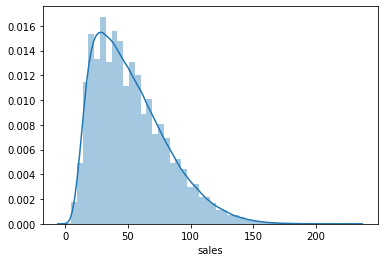

In [3]:
sns.distplot(train['sales'])
print('The maximum amount of sales is %s.' % (max(train['sales'])))
print('The average amount of sales is %.2f.' % (np.mean(train['sales'])))
print('The median amount of sales is %.2f.' % (np.median(train['sales'])))

In [4]:
train.sample(10)

,date,store,item,sales
636529,2015-12-18,9,35,49
78927,2014-02-14,4,5,17
857111,2014-12-19,10,47,16
893994,2015-12-17,10,49,23
412596,2017-10-13,6,23,18
272279,2013-07-25,10,15,101
354649,2014-02-10,5,20,23
539141,2014-04-17,6,30,21
840556,2014-08-20,1,47,26
278262,2014-12-12,3,16,27


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
date     913000 non-null datetime64[ns]
store    913000 non-null int64
item     913000 non-null int64
sales    913000 non-null int64
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


In [6]:
train.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [7]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


So there are 10 stores with 50 different products. The sales for each item range between 0 and 231, but they are mainly around the 30-70 range. There is five years worth of sales data (2013-2017) to train on and the goal is the predict the sales for the next 3 months.

In [8]:
sample = train.loc[train['store'] == 5].loc[train['item'] == 1]

/Users/Philip/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


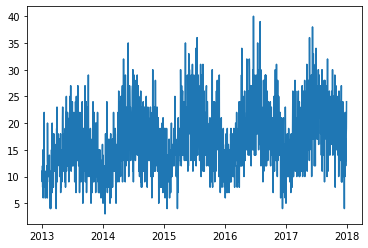

In [9]:
plt.plot(sample['date'], sample['sales'])

In [10]:
sample

,date,store,item,sales
7304,2013-01-01,5,1,11
7305,2013-01-02,5,1,9
7306,2013-01-03,5,1,12
7307,2013-01-04,5,1,8
7308,2013-01-05,5,1,13
...,...,...,...,...
9125,2017-12-27,5,1,15
9126,2017-12-28,5,1,13
9127,2017-12-29,5,1,18
9128,2017-12-30,5,1,19


In [11]:
train['day_of_week'] = train['date'].dt.dayofweek

There is definitely a pattern with sales generally going up in the summer and going down in the winter with a trend of increasing sales year after year. The day of the week might also have some effect on the trend.

In [12]:
#sns.barplot(x='day_of_week', y = 'sales', data = train)

Sales patterns seem to vary depending on what day it is. Sales are the lowest on Mondays and continue to raise to its peak on Sundays.

In [13]:
#sns.barplot(x='store', y = 'sales', data = train)

In [14]:
#sns.barplot(x='item', y = 'sales', data = train)

## Preprocessing
Here we create a windowed dataset to preprocess the data

In [15]:
sample['day_of_week'] = sample['date'].dt.dayofweek

In [16]:
def create_data_windows(df, width):
    """Function: Takes in the DataFrame, df, and splits it into rolling windows of size width to be used in a neural network.
    It outputs a dataframe and a target dataframe, which is the sales number to be predicted.
    Inputs: df - dataframe with columns [date, store, item, sales]
            width - the with of the window including the last sales data which will be the target
    Outputs: df_windowed - dataframe with the day of the week of the last day of the window, the store, and item numbers
                            along with the windowed sales data
             df_target - dataframe that contains the target date and target sales"""

    # Initalize output datasets
    windowed_data = np.empty([len(df)-width+1, width+2])
    df = df.reset_index(drop = True)
    
    # Create windows. E.g. [1, 2, 3, 4, 5, 6, 7] -> [[1,2,3,4], [2,3,4,5], [3,4,5,6]]
    # Also creates targets which would be [[5], [6], [7]] in the above case
    for i in range(len(df)-width+1):
        row = list(df.iloc[i:i+width-1]['sales'])
        row_info = [df.loc[i,'day_of_week'], df.loc[i, 'store'], df.loc[i, 'item']]
        row = row_info + row
        windowed_data[i,:] = row
        
    # Create a DataFrame to contain the windowed data
    windowed_columns = ['day_of_week', 'store', 'item'] + list(map(str,(range(1,width))))
    
    df_windowed = pd.DataFrame(data = windowed_data, 
                               columns = windowed_columns,
                               dtype = 'int')
    
    # Create target dataset
    df_target = pd.DataFrame(data = df.loc[width-1::, ['date', 'sales']]).reset_index(drop = True)
        
    return df_windowed, df_target

In [17]:
window_size = 10
df, df_target = create_data_windows(sample, window_size)

In [18]:
df

,day_of_week,store,item,1,2,3,4,5,6,7,8,9
0,1,5,1,11,9,12,8,13,15,6,11,13
1,2,5,1,9,12,8,13,15,6,11,13,9
2,3,5,1,12,8,13,15,6,11,13,9,9
3,4,5,1,8,13,15,6,11,13,9,9,8
4,5,5,1,13,15,6,11,13,9,9,8,22
...,...,...,...,...,...,...,...,...,...,...,...,...
1812,0,5,1,4,16,13,10,14,22,14,17,12
1813,1,5,1,16,13,10,14,22,14,17,12,15
1814,2,5,1,13,10,14,22,14,17,12,15,13
1815,3,5,1,10,14,22,14,17,12,15,13,18


In [19]:
df_target

,date,sales
0,2013-01-10,9
1,2013-01-11,9
2,2013-01-12,8
3,2013-01-13,22
4,2013-01-14,8
...,...,...
1812,2017-12-27,15
1813,2017-12-28,13
1814,2017-12-29,18
1815,2017-12-30,19


In [20]:
# Train-test split
sample_train_df, sample_train_target = df.iloc[:-365], df_target.iloc[:-365]
sample_val_df, sample_val_target = df.iloc[-365::], df_target.iloc[-365::]

In [21]:
sample_train_df

,day_of_week,store,item,1,2,3,4,5,6,7,8,9
0,1,5,1,11,9,12,8,13,15,6,11,13
1,2,5,1,9,12,8,13,15,6,11,13,9
2,3,5,1,12,8,13,15,6,11,13,9,9
3,4,5,1,8,13,15,6,11,13,9,9,8
4,5,5,1,13,15,6,11,13,9,9,8,22
...,...,...,...,...,...,...,...,...,...,...,...,...
1447,6,5,1,15,10,13,14,7,16,16,15,10
1448,0,5,1,10,13,14,7,16,16,15,10,9
1449,1,5,1,13,14,7,16,16,15,10,9,6
1450,2,5,1,14,7,16,16,15,10,9,6,23


In [22]:
sample_train_target

,date,sales
0,2013-01-10,9
1,2013-01-11,9
2,2013-01-12,8
3,2013-01-13,22
4,2013-01-14,8
...,...,...
1447,2016-12-27,9
1448,2016-12-28,6
1449,2016-12-29,23
1450,2016-12-30,16


Turn dataframes into tensors to prepare them to be fed into neural network in pytorch

In [23]:
training_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sample_train_df)), torch.FloatTensor(np.array(sample_train_target['sales'])))
validation_dataset = torch.utils.data.TensorDataset(torch.FloatTensor(np.array(sample_val_df)), torch.FloatTensor(np.array(sample_val_target['sales'])))

# Neural Network

Initalize Neural Network

In [24]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        nn.init.constant_(m.bias,0)
        
class Net(nn.Module):
    def __init__(self, split_pos, window_length, n_hidden_1, n_hidden_2, D_out, p=0.0):
        super().__init__()
        
        # Subtract 1 because that's the target length
        self.window_length = window_length - 1
        self.split_pos = split_pos
        
        self.lstm1 = nn.LSTM(1, n_hidden_1, bidirectional = False, batch_first = True)
        
        self.fc1 = nn.Linear(n_hidden_1 + split_pos, n_hidden_2)
        # self.drop1 = nn.Dropout(p=p)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_2, D_out)
        self.out_act = nn.Sigmoid()
        
    def forward(self, x):
        # Split input tensor. x_seq will be fed into the lstm.
        print(x.size())
        x_info, x_seq = x[:,:3], x[:,3:]
        print(x_info.size())
        
        # LSTM layer
        x_seq = torch.unsqueeze(x_seq, 2)
        print(x_seq.size())
        print(x_seq[0:2,:,:])
        lstm_out, (h, c) = self.lstm1(x_seq)
        
        # Combine the extra info to the lstm results using the output of the last lstm neuron
        lstm_output = lstm_out[:,:,1]
        print(lstm_output.size())
        
        combo_out = torch.cat([lstm_output, x_info], 1)
        
        # Fully connected layer
        fc1_out = self.fc1(combo_out)
        fc1_out = self.relu1(fc1_out)
        
        # Output layer
        y = self.out_act(self.fc2(fc1_out))
        #print(y.size())
        
        # Squeeze to remove extra dimensions of size 1
        return torch.squeeze(y)

In [25]:
def train_model(data_set, model, criterion, train_loader, validation_loader, optimizer, epochs=10):
    model.train()
    loss_accuracy = {'training_loss':[], 'validation_accuracy':[], 'validation_precision':[], 'validation_recall':[]}
    
    for epoch in range(epochs):
        #clear_output(wait=True)
        print("Epoch {} / {}\n=============".format(epoch+1, epochs))
            

        
        train_correct = 0
        for x, y in train_loader:
            optimizer.zero_grad()
            ## Forward pass
            yhat = model(x)
            ## Compute loss
            loss = criterion(yhat, y)
            ## Compute gradient in backward pass
            loss.backward()
            ## Update weights
            optimizer.step()
            
            yhat = np.where(yhat.detach().numpy() > 0.5, 1, 0)
            train_correct += (yhat == y.numpy()).sum()
            
            loss_accuracy['training_loss'].append(loss.item())
         
        ## Compute validation accuracy
        model.eval()
        correct = 0
        for x, y in validation_loader:
            yhat = net(x)           
            yhat = np.where(yhat.detach().numpy() > 0.5, 1, 0)
            correct = (yhat == y.detach().numpy()).sum()                        
            accuracy = 100 * (correct / validation_loader.batch_size)
            
        loss_accuracy['validation_accuracy'].append(accuracy)
        
        ## Print training loss and accuracy, and validation accuracy
        train_acc = 100 * train_correct / len(train_loader.dataset)
        print("Training loss: {} | Training accuracy: {:.2f}%\nValidation accuracy: {:.2f}%".format(loss.item(), train_acc, accuracy))
        
        model.train()
        
        ## Add precision and recall
        
    print("Training complete!")
                
    return loss_accuracy

In [26]:
epochs = 10
learning_rate = 0.001

## Network dimensions
split_pos = 3
n_hidden_1 = 12
n_hidden_2 = 32
D_out = 1
batch_size = 128
reg_lambda = 0
momentum_coef = 0.9
dropout_percent = 0.0

## Load data
train_loader = torch.utils.data.DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset), shuffle=False)

## Initialize model
net = Net(split_pos, window_size, n_hidden_1, n_hidden_2, D_out, p = dropout_percent)
net.apply(weights_init)


optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay = reg_lambda)
criterion = nn.BCELoss()

In [ ]:
epochs = 10
## Train the model
loss_accuracy = train_model(training_dataset, net, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

In [ ]:
## Plots
fig = plt.figure(1)
plt.plot(loss_accuracy['training_loss'], color="red")
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [-]")

fig = plt.figure(2)
plt.plot(loss_accuracy['validation_accuracy'], color="blue")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy [%]")